In [6]:
#!/usr/bin/env python
import lz4.frame as lz4f
import cloudpickle
import json
import pprint
import numpy as np
import awkward
np.seterr(divide='ignore', invalid='ignore', over='ignore')
from coffea.arrays import Initialize
from coffea import hist, processor
from coffea.util import load, save
from coffea.jetmet_tools import FactorizedJetCorrector, JetCorrectionUncertainty, JetTransformer, JetResolution, JetResolutionScaleFactor
from optparse import OptionParser
from uproot_methods import TVector2Array, TLorentzVectorArray

## Objectives

### A. No tight/loose selection applied
1. plot electron pt, $\eta$, $\phi$ for events passing electron triggers
2. plot muon pt, $\eta$, $\phi$ for events passing muon triggers
3. plot met pt, $\eta$, $\phi$ for events passing met triggers

### B. Tight selection applied
1. plot electron pt, $\eta$, $\phi$ for events passing electron triggers
2. plot muon pt, $\eta$, $\phi$ for events passing muon triggers
3. plot met pt, $\eta$, $\phi$ for events passing met triggers

### C. Loose selection applied
1. plot electron pt, $\eta$, $\phi$ for events passing electron triggers
2. plot muon pt, $\eta$, $\phi$ for events passing muon triggers
3. plot met pt, $\eta$, $\phi$ for events passing met triggers

In [72]:
class AnalysisProcessor(processor.ProcessorABC):
    def __init__(self):

        self._accumulator = processor.dict_accumulator({

            'sumw': hist.Hist(
                'sumw', 
                hist.Cat('dataset', 'Dataset'), 
                hist.Bin('sumw', 'Weight value', [0.])
            ),

            'ele_pT': hist.Hist(
                'Events',
                hist.Cat('dataset', 'dataset'),
                hist.Cat('flavor', 'tight or loose'),
                hist.Bin('pT', 'electron $p_{T}$ [GeV]', 10, 0, 200)),

            'mu_pT': hist.Hist(
                'Events',
                hist.Cat('dataset', 'dataset'),
                hist.Cat('flavor', 'tight or loose'),
                hist.Bin('pT', 'mu $p_{T}$ [GeV]', 10, 0, 200))
        })

    @property
    def accumulator(self):
        return self._accumulator

    def process(self, events):

        # This gets us the accumulator dictionary we defined in init
        output = self.accumulator.identity()

        dataset = events.metadata['dataset'].split('_')[0]

        Electron = events.Electron
        Muon = events.Muon
        Met = events.MET
        Jet = events.Jet
        
        TightEleSel = ~(Electron.pt == np.nan)
        TightEleSel = (((Electron.pt > 40) &
                      (abs(Electron.eta) < 1.4442) &
                      (abs(Electron.dxy) < 0.05) &
                      (abs(Electron.dz) < 0.1) &
                      (Electron.cutBased == 4)) |
                     ((Electron.pt > 40) &
                      (abs(Electron.eta) > 1.5660) &
                      (abs(Electron.eta) < 2.5) &
                      (abs(Electron.dxy) < 0.1) &
                      (abs(Electron.dz) < 0.2) &
                      (Electron.cutBased == 4)
                      ))  # Trigger: HLT_Ele32_WPTight_Gsf_v

        LooseEleSel = ~(Electron.pt == np.nan)
        LooseEleSel = (((Electron.pt > 10) &
                      (abs(Electron.eta) < 1.4442) &
                      (abs(Electron.dxy) < 0.05) &
                      (abs(Electron.dz) < 0.1) &
                      (Electron.cutBased >= 1)) |
                     ((Electron.pt > 10) &
                      (abs(Electron.eta) > 1.5660) &
                      (abs(Electron.eta) < 2.5) &
                      (abs(Electron.dxy) < 0.1) &
                      (abs(Electron.dz) < 0.2) &
                      (Electron.cutBased >= 1)))
        
        Muon['T'] = TVector2Array.from_polar(Muon.pt, Muon.phi)
        Muon['p4'] = TLorentzVectorArray.from_ptetaphim(Muon.pt, Muon.eta, Muon.phi, Muon.mass)
        
        TightMuSel = ~(Muon.pt==np.nan)
        TightMuSel = (
                    (Muon.pt>30) &
                    (abs(Muon.eta)<2.4) &
                    (Muon.tightId) &
                    (Muon.pfRelIso04_all<0.15)
                    )
        
        LooseMuonSel = ~(Muon.pt==np.nan)
        LooseMuonSel = (Muon.pt>15)&(abs(Muon.eta)<2.4)&(Muon.looseId>0)&(Muon.pfRelIso04_all<0.25)
        
        LooseMuon = Muon[LooseMuonSel]
        TightMuon = Muon[TightMuSel]
        LeadingMu = TightMuon[TightMuon.pt.argmax()]

        TightElectron = Electron[TightEleSel]
        LooseElectron = Electron[LooseEleSel]
        LeadingEle = TightElectron[TightElectron.pt.argmax()]
        
        # single e triggers for e events
        EleTrigger = ['Ele32_WPTight_Gsf',
                    'Ele115_CaloIdVT_GsfTrkIdT', 'Photon200']
        MuTrigger = ['IsoMu24',
            'Mu50',
            'OldMu100',
            'TkMu100']
        MetTrigger = ['PFMETNoMu120_PFMHTNoMu120_IDTight_PFHT60','PFMETNoMu120_PFMHTNoMu120_IDTight'] 
        
        selection = processor.PackedSelection()
        
        all_true =np.full(events.size, True, dtype=np.bool)
        selection.add('all_true', all_true)
        
        triggers = np.zeros(events.size, dtype=np.bool)
        for path in EleTrigger:
            if path not in events.HLT.columns:
                continue
            triggers = triggers | events.HLT[path]
        selection.add('ele_triggers', triggers)
        
        triggers = np.zeros(events.size, dtype=np.bool)
        for path in MuTrigger:
            if path not in events.HLT.columns: continue
            triggers = triggers | events.HLT[path]
        selection.add('mu_triggers', triggers)

        triggers = np.zeros(events.size, dtype=np.bool)
        for path in MetTrigger:
            if path not in events.HLT.columns: continue
            triggers = triggers | events.HLT[path]
        selection.add('met_triggers', triggers)
#         selection.add('TightMet', (Met.T >= 100))
        
        
        EleTrigSel = selection.all(*('ele_triggers', 'all_true'))
        MuTrigSel = selection.all(*('mu_triggers', 'all_true'))
        MetTrigSel = selection.all(*('met_triggers', 'all_true'))
#         print(EleTrigSel)

#************* Histogram filling *************************

        
      
        output['ele_pT'].fill(dataset=dataset,
                    flavor='nosel',
                    pT=Electron.pt[:,:1][EleTrigSel].flatten()) 
     
        output['ele_pT'].fill(dataset=dataset,
                    flavor='noselnotrig',
                    pT=Electron.pt[:,:1].flatten()) 
        
      
        output['mu_pT'].fill(dataset=dataset,
                    flavor='nosel',
                    pT=Muon.pt[:,:1][MuTrigSel].flatten()) 
     
        output['mu_pT'].fill(dataset=dataset,
                    flavor='noselnotrig',
                    pT=Muon.pt[:,:1].flatten()) 
        
        
        output['sumw'].fill(dataset=dataset, sumw=1, weight=1)


        return output
        
    def postprocess(self, accumulator):


        return accumulator        

In [73]:
fileset = {'WJetsToLNu_HT-100To200_TuneCP5_13TeV-madgraphMLM-pythia8____1_':
[
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/WJetsToLNu_HT-100To200_TuneCP5_13TeV-madgraphMLM-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v1/191207_092936/0000/nano_128.root",
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/WJetsToLNu_HT-100To200_TuneCP5_13TeV-madgraphMLM-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v1/191207_092936/0000/nano_129.root",
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/WJetsToLNu_HT-100To200_TuneCP5_13TeV-madgraphMLM-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v1/191207_092936/0000/nano_13.root",
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/WJetsToLNu_HT-100To200_TuneCP5_13TeV-madgraphMLM-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v1/191207_092936/0000/nano_130.root",
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/WJetsToLNu_HT-100To200_TuneCP5_13TeV-madgraphMLM-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v1/191207_092936/0000/nano_131.root",
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/WJetsToLNu_HT-100To200_TuneCP5_13TeV-madgraphMLM-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v1/191207_092936/0000/nano_132.root",
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/WJetsToLNu_HT-100To200_TuneCP5_13TeV-madgraphMLM-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v1/191207_092936/0000/nano_133.root",
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/WJetsToLNu_HT-100To200_TuneCP5_13TeV-madgraphMLM-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v1/191207_092936/0000/nano_134.root",
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/WJetsToLNu_HT-100To200_TuneCP5_13TeV-madgraphMLM-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v1/191207_092936/0000/nano_135.root",
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/WJetsToLNu_HT-100To200_TuneCP5_13TeV-madgraphMLM-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v1/191207_092936/0000/nano_136.root",
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/WJetsToLNu_HT-100To200_TuneCP5_13TeV-madgraphMLM-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v1/191207_092936/0000/nano_137.root",
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/WJetsToLNu_HT-100To200_TuneCP5_13TeV-madgraphMLM-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v1/191207_092936/0000/nano_138.root",
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/WJetsToLNu_HT-100To200_TuneCP5_13TeV-madgraphMLM-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v1/191207_092936/0000/nano_139.root",
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/WJetsToLNu_HT-100To200_TuneCP5_13TeV-madgraphMLM-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v1/191207_092936/0000/nano_14.root",
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/WJetsToLNu_HT-100To200_TuneCP5_13TeV-madgraphMLM-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v1/191207_092936/0000/nano_140.root",
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/WJetsToLNu_HT-100To200_TuneCP5_13TeV-madgraphMLM-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v1/191207_092936/0000/nano_141.root",
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/WJetsToLNu_HT-100To200_TuneCP5_13TeV-madgraphMLM-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v1/191207_092936/0000/nano_142.root",
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/WJetsToLNu_HT-100To200_TuneCP5_13TeV-madgraphMLM-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v1/191207_092936/0000/nano_143.root",
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/WJetsToLNu_HT-100To200_TuneCP5_13TeV-madgraphMLM-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v1/191207_092936/0000/nano_144.root",
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/WJetsToLNu_HT-100To200_TuneCP5_13TeV-madgraphMLM-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v1/191207_092936/0000/nano_145.root",
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/WJetsToLNu_HT-100To200_TuneCP5_13TeV-madgraphMLM-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v1/191207_092936/0000/nano_146.root",
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/WJetsToLNu_HT-100To200_TuneCP5_13TeV-madgraphMLM-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v1/191207_092936/0000/nano_147.root",
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/WJetsToLNu_HT-100To200_TuneCP5_13TeV-madgraphMLM-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v1/191207_092936/0000/nano_148.root",
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/WJetsToLNu_HT-100To200_TuneCP5_13TeV-madgraphMLM-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v1/191207_092936/0000/nano_149.root",
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/WJetsToLNu_HT-100To200_TuneCP5_13TeV-madgraphMLM-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v1/191207_092936/0000/nano_15.root",
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/WJetsToLNu_HT-100To200_TuneCP5_13TeV-madgraphMLM-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v1/191207_092936/0000/nano_150.root",
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/WJetsToLNu_HT-100To200_TuneCP5_13TeV-madgraphMLM-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v1/191207_092936/0000/nano_151.root",
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/WJetsToLNu_HT-100To200_TuneCP5_13TeV-madgraphMLM-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v1/191207_092936/0000/nano_152.root",
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/WJetsToLNu_HT-100To200_TuneCP5_13TeV-madgraphMLM-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v1/191207_092936/0000/nano_153.root",
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/WJetsToLNu_HT-100To200_TuneCP5_13TeV-madgraphMLM-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v1/191207_092936/0000/nano_154.root",
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/WJetsToLNu_HT-100To200_TuneCP5_13TeV-madgraphMLM-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v1/191207_092936/0000/nano_155.root",
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/WJetsToLNu_HT-100To200_TuneCP5_13TeV-madgraphMLM-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v1/191207_092936/0000/nano_156.root"
        ],
#           'DYJetsToLL_M-50_HT-100to200_TuneCP5_PSweights_13TeV-madgraphMLM-pythia8____0_':
#           [
#             "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/DYJetsToLL_M-50_HT-100to200_TuneCP5_PSweights_13TeV-madgraphMLM-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v2/191207_044342/0000/nano_1.root",
#             "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/DYJetsToLL_M-50_HT-100to200_TuneCP5_PSweights_13TeV-madgraphMLM-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v2/191207_044342/0000/nano_10.root",
#             "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/DYJetsToLL_M-50_HT-100to200_TuneCP5_PSweights_13TeV-madgraphMLM-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v2/191207_044342/0000/nano_100.root",
#             "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/DYJetsToLL_M-50_HT-100to200_TuneCP5_PSweights_13TeV-madgraphMLM-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v2/191207_044342/0000/nano_101.root",
#             "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/DYJetsToLL_M-50_HT-100to200_TuneCP5_PSweights_13TeV-madgraphMLM-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v2/191207_044342/0000/nano_102.root",
#             "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/DYJetsToLL_M-50_HT-100to200_TuneCP5_PSweights_13TeV-madgraphMLM-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v2/191207_044342/0000/nano_103.root",
#             "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/DYJetsToLL_M-50_HT-100to200_TuneCP5_PSweights_13TeV-madgraphMLM-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v2/191207_044342/0000/nano_104.root",
#             "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/DYJetsToLL_M-50_HT-100to200_TuneCP5_PSweights_13TeV-madgraphMLM-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v2/191207_044342/0000/nano_105.root",
#             "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/DYJetsToLL_M-50_HT-100to200_TuneCP5_PSweights_13TeV-madgraphMLM-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v2/191207_044342/0000/nano_106.root",
#             "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/DYJetsToLL_M-50_HT-100to200_TuneCP5_PSweights_13TeV-madgraphMLM-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v2/191207_044342/0000/nano_107.root",
#             "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/DYJetsToLL_M-50_HT-100to200_TuneCP5_PSweights_13TeV-madgraphMLM-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v2/191207_044342/0000/nano_108.root",
#             "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/DYJetsToLL_M-50_HT-100to200_TuneCP5_PSweights_13TeV-madgraphMLM-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v2/191207_044342/0000/nano_109.root",
#             "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/DYJetsToLL_M-50_HT-100to200_TuneCP5_PSweights_13TeV-madgraphMLM-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v2/191207_044342/0000/nano_11.root",
#             "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/DYJetsToLL_M-50_HT-100to200_TuneCP5_PSweights_13TeV-madgraphMLM-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v2/191207_044342/0000/nano_110.root",
#             "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/DYJetsToLL_M-50_HT-100to200_TuneCP5_PSweights_13TeV-madgraphMLM-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v2/191207_044342/0000/nano_111.root",
#             "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/DYJetsToLL_M-50_HT-100to200_TuneCP5_PSweights_13TeV-madgraphMLM-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v2/191207_044342/0000/nano_112.root",
#             "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/DYJetsToLL_M-50_HT-100to200_TuneCP5_PSweights_13TeV-madgraphMLM-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v2/191207_044342/0000/nano_113.root",
#             "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/DYJetsToLL_M-50_HT-100to200_TuneCP5_PSweights_13TeV-madgraphMLM-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v2/191207_044342/0000/nano_114.root",
#             "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/DYJetsToLL_M-50_HT-100to200_TuneCP5_PSweights_13TeV-madgraphMLM-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v2/191207_044342/0000/nano_115.root",
#             "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/DYJetsToLL_M-50_HT-100to200_TuneCP5_PSweights_13TeV-madgraphMLM-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v2/191207_044342/0000/nano_116.root",
#             "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/DYJetsToLL_M-50_HT-100to200_TuneCP5_PSweights_13TeV-madgraphMLM-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v2/191207_044342/0000/nano_117.root",
#             "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/DYJetsToLL_M-50_HT-100to200_TuneCP5_PSweights_13TeV-madgraphMLM-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v2/191207_044342/0000/nano_118.root",
#             "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/DYJetsToLL_M-50_HT-100to200_TuneCP5_PSweights_13TeV-madgraphMLM-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v2/191207_044342/0000/nano_119.root",
#             "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/DYJetsToLL_M-50_HT-100to200_TuneCP5_PSweights_13TeV-madgraphMLM-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v2/191207_044342/0000/nano_12.root",
#             "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/DYJetsToLL_M-50_HT-100to200_TuneCP5_PSweights_13TeV-madgraphMLM-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v2/191207_044342/0000/nano_120.root",
#             "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/DYJetsToLL_M-50_HT-100to200_TuneCP5_PSweights_13TeV-madgraphMLM-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v2/191207_044342/0000/nano_121.root",
#             "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/DYJetsToLL_M-50_HT-100to200_TuneCP5_PSweights_13TeV-madgraphMLM-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v2/191207_044342/0000/nano_122.root",
#             "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/DYJetsToLL_M-50_HT-100to200_TuneCP5_PSweights_13TeV-madgraphMLM-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v2/191207_044342/0000/nano_123.root",
#             "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/DYJetsToLL_M-50_HT-100to200_TuneCP5_PSweights_13TeV-madgraphMLM-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v2/191207_044342/0000/nano_124.root",
#             "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/DYJetsToLL_M-50_HT-100to200_TuneCP5_PSweights_13TeV-madgraphMLM-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v2/191207_044342/0000/nano_125.root",
#             "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/DYJetsToLL_M-50_HT-100to200_TuneCP5_PSweights_13TeV-madgraphMLM-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v2/191207_044342/0000/nano_126.root",
#             "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/DYJetsToLL_M-50_HT-100to200_TuneCP5_PSweights_13TeV-madgraphMLM-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v2/191207_044342/0000/nano_127.root"
#         ],
#          'MET____0_'  :
#            [
#             "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/MET/NanoTuples-2018_Run2018A-17Sep2018-v1/191206_204012/0000/nano_1.root",
#             "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/MET/NanoTuples-2018_Run2018A-17Sep2018-v1/191206_204012/0000/nano_10.root",
#             "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/MET/NanoTuples-2018_Run2018A-17Sep2018-v1/191206_204012/0000/nano_100.root",
#             "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/MET/NanoTuples-2018_Run2018A-17Sep2018-v1/191206_204012/0000/nano_101.root",
#             "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/MET/NanoTuples-2018_Run2018A-17Sep2018-v1/191206_204012/0000/nano_102.root",
#             "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/MET/NanoTuples-2018_Run2018A-17Sep2018-v1/191206_204012/0000/nano_103.root",
#             "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/MET/NanoTuples-2018_Run2018A-17Sep2018-v1/191206_204012/0000/nano_104.root",
#             "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/MET/NanoTuples-2018_Run2018A-17Sep2018-v1/191206_204012/0000/nano_105.root",
#             "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/MET/NanoTuples-2018_Run2018A-17Sep2018-v1/191206_204012/0000/nano_106.root",
#             "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/MET/NanoTuples-2018_Run2018A-17Sep2018-v1/191206_204012/0000/nano_107.root",
#             "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/MET/NanoTuples-2018_Run2018A-17Sep2018-v1/191206_204012/0000/nano_108.root",
#             "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/MET/NanoTuples-2018_Run2018A-17Sep2018-v1/191206_204012/0000/nano_109.root",
#             "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/MET/NanoTuples-2018_Run2018A-17Sep2018-v1/191206_204012/0000/nano_11.root",
#             "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/MET/NanoTuples-2018_Run2018A-17Sep2018-v1/191206_204012/0000/nano_110.root",
#             "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/MET/NanoTuples-2018_Run2018A-17Sep2018-v1/191206_204012/0000/nano_111.root",
#             "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/MET/NanoTuples-2018_Run2018A-17Sep2018-v1/191206_204012/0000/nano_112.root",
#             "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/MET/NanoTuples-2018_Run2018A-17Sep2018-v1/191206_204012/0000/nano_113.root",
#             "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/MET/NanoTuples-2018_Run2018A-17Sep2018-v1/191206_204012/0000/nano_114.root",
#             "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/MET/NanoTuples-2018_Run2018A-17Sep2018-v1/191206_204012/0000/nano_115.root",
#             "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/MET/NanoTuples-2018_Run2018A-17Sep2018-v1/191206_204012/0000/nano_116.root",
#             "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/MET/NanoTuples-2018_Run2018A-17Sep2018-v1/191206_204012/0000/nano_117.root",
#             "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/MET/NanoTuples-2018_Run2018A-17Sep2018-v1/191206_204012/0000/nano_118.root",
#             "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/MET/NanoTuples-2018_Run2018A-17Sep2018-v1/191206_204012/0000/nano_119.root",
#             "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/MET/NanoTuples-2018_Run2018A-17Sep2018-v1/191206_204012/0000/nano_12.root",
#             "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/MET/NanoTuples-2018_Run2018A-17Sep2018-v1/191206_204012/0000/nano_120.root",
#             "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/MET/NanoTuples-2018_Run2018A-17Sep2018-v1/191206_204012/0000/nano_121.root",
#             "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/MET/NanoTuples-2018_Run2018A-17Sep2018-v1/191206_204012/0000/nano_122.root",
#             "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/MET/NanoTuples-2018_Run2018A-17Sep2018-v1/191206_204012/0000/nano_123.root",
#             "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/MET/NanoTuples-2018_Run2018A-17Sep2018-v1/191206_204012/0000/nano_124.root",
#             "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/MET/NanoTuples-2018_Run2018A-17Sep2018-v1/191206_204012/0000/nano_125.root",
#             "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/MET/NanoTuples-2018_Run2018A-17Sep2018-v1/191206_204012/0000/nano_126.root",
#             "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/MET/NanoTuples-2018_Run2018A-17Sep2018-v1/191206_204012/0000/nano_127.root"
#         ]
}
#Run Coffea code using uproot
output = processor.run_uproot_job(fileset,
                                  treename='Events',
                                  processor_instance=AnalysisProcessor(),
                                  executor=processor.futures_executor,
                                  executor_args={'workers': 4, 'flatten': True, 'nano':True},
                                 )

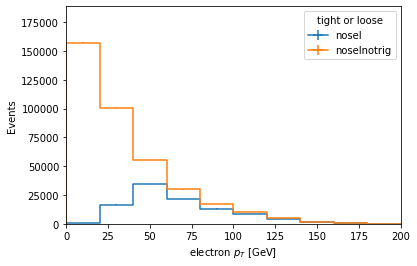

In [77]:
hist.plot1d(output['ele_pT'].integrate('dataset'), overlay='flavor')

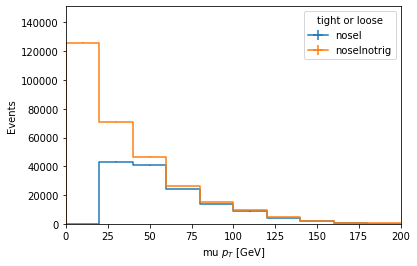

In [76]:
hist.plot1d(output['mu_pT'].integrate('dataset'), overlay='flavor')

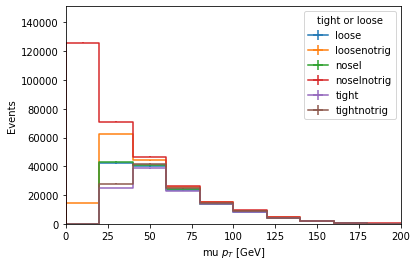

In [71]:
hist.plot1d(output['mu_pT'].integrate('dataset'), overlay='flavor')